<a href="https://colab.research.google.com/github/apstemmer/keras_triplet_descriptor/blob/master/baseline_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline code
This code introduces a two-step training for the problem. It may be better doing only one-step, i.e. from noisy patch to descriptor directly, but this provides an initial valid submission to use as a first step.

The outputs you see here are with only some minutes of training, so results should be better if the models are trained for more time.

Testing a commit from Colab



## Importing necessary modules

We now import the modules we will use in this baseline code. The read_data and utils imports are function provided in the repository we just cloned.

In [1]:
import sys
import json
import os
import glob
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate 
# import talos
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [2]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

The HPatches dataset has several splits, where it separates the sequences available in train sequences and test sequences. We load the split 'a'. 

In [3]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


## Models and loss

We now define three functions that define main modules of our baseline. First, we have a function that returns a denoising model. The input for the function is the size of the patch, which will be 1x64x64, and it outputs a keras model.

Then we have a similar function for the descriptor model, the model we use as baseline takes as input a patch of size 1x32x32, and returns a descriptor. Then we will use the triplet loss.

You can modify the models in this functions and run the training code again for your new models. For example, the given UNet is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weigths. Or maybe adding dropout. Or modifying the loss somehow....

In [4]:
def get_descriptor_model(shape):
    '''Architecture copies HardNet architecture'''
    init_weights = keras.initializers.he_normal()
    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))
    descriptor_model.add(Dropout(0.3))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(Reshape((128,)))
    return descriptor_model
  
  
def triplet_loss(x):
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)
    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Training a Descriptor Network
Now we train the network that generates the descriptors for the patch. We are going to use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

In [5]:
from keras.layers import Lambda
shape = (29, 29, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs = [xa, xp, xn], outputs = loss)
sgd = keras.optimizers.SGD(lr = 0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Here we use the class HPatches, which loads the corresponding files by using the method read_image_file. It reads the clean patches, which are the ones used for training in this baseline code. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class DataGeneratorDesc. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

In [6]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames = train_fnames, test_fnames = test_fnames, use_clean = True)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 1), num_triplets = 100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 0), num_triplets = 10000)


Using clean patches
100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:01<00:00, 69018.98it/s]


Using clean patches
100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

100%|██████████| 10000/10000 [00:00<00:00, 73859.63it/s]

We plot a random triplet in the form of anchor, positive and negative sample

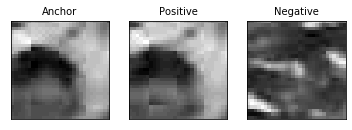

In [12]:
# plot_triplet(training_generator)

import matplotlib.pyplot as plt
a = next(iter(training_generator))
index = np.random.randint(0, a[0]['a'].shape[0])
plt.subplot(131)
plt.imshow(a[0]['a'][index,:,:,0], cmap='gray') 
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.title('Anchor', fontsize=10)
plt.subplot(132)
plt.imshow(a[0]['p'][index,:,:,0], cmap='gray') 
plt.title('Positive', fontsize=10)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(133)
plt.imshow(a[0]['n'][index,:,:,0], cmap='gray') 
plt.title('Negative', fontsize=10)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

We now train the descriptor model and save the weights afterward.

In [ ]:
history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_model.save_weights('hardnet.h5') 

Epoch 1/1
  17/2000 [..............................] - ETA: 54:36 - loss: 0.5954

## Generating descriptors files for test data 

HPatches benchmark takes as input the descriptors for the test data in a CSV form. This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to None), the descriptor is computed directly in the noisy patch.

In [ ]:
generate_desc_csv(descriptor_model, denoise_model, seqs_test)

## Evaluating descriptors in HPatches Benchmark
We first download the official repository for HPatches Benchmark.

In [ ]:
!git clone https://github.com/hpatches/hpatches-benchmark


Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script.

### Verification



In [ ]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=verification


### Matching

In [ ]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=matching


### Retrieval

In [ ]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=retrieval


## Compressing and saving the CSV files 

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [ ]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [ ]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')